## Customer Churn Prediction 

### Project Overview
* Created a XGBoost Classification Model to predict a telecommunication company customers decision to stay or leave, predicting 81% of the churn cases.
* Analyzed customers information dividing it different groups.
* Plotted and analyzed evaluation metrics curves and feature importances.


### Code and Resources Used 
**Python Version:** 3.7  
**Packages:** pandas, numpy, matplotlib, seaborn, sklearn.

### Dataset
The dataset is taken from Leaps Analyttica (www.leaps.analyttica.com/) and contains services, account and demographic information of 10000 customers of a telecommunication company represented in 21 features. Data is highly unbalanced with respect to the target.  
Dataset: https://www.kaggle.com/datasets/blastchar/telco-customer-churn 

### EDA
* Features grouping and distribution analysis.
* Continuous variables analysis against different groups.
* Correlation analysis

### Data preparation
Categorical data was encoded into dummy variables and splited in train (80%) and test (20%) sets.

### Models Building and Performance
An XGBoost Model was tuned with GridSeachCV obtaining:

* **XGBoost**: precision=0.41, recall=0.81, f1-score=0.61.

### Metrics Chosen 
**Precision, Recall, F1-score.** 

All 3 metrics from the classification report were used for results clear interpretaion and confusion matrix results were printed.

### Notebook content:

1. Exploratory Data Analysis
2. Data Preparation
3. Models Training, Evaluation and Error Analysis
4. Conclusion

### 1. Exploratory Data Analysis
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from xgboost import XGBClassifier
from xgboost import plot_importance
from time import time

In [4]:
ds = pd.read_csv('dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
print(f'Dataset shape: {ds.shape}')
print(f'Dataset format: {type(ds)}')

Dataset shape: (7043, 21)
Dataset format: <class 'pandas.core.frame.DataFrame'>


In [6]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Analizing the dataset columns we can identify:

- Our Label:
    - Customers who left within the last month: Churn  
    

- Our Features, which we will divide in 3 groups:
    - Services customer signed up for: PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV and StreamingMovies.
    - Customer account information: tenure (months as customer), Contract (contract term: Month-to-month, One year, Two year), PaperlessBilling, PaymentMethod, MonthlyCharges and TotalCharges.  
    - Customer Demographic info: gender, SeniorCitizen (age range), Partner and Dependents (if the customer has partners and dependents).  

We create a work copy of the original dataset:

In [7]:
df = ds.copy()

In [8]:
df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


'TotalCharges' values are in string format so we transform them into numerical:

In [24]:
type(df['TotalCharges'][1])

str

In [9]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

#### Data filtering

We check for null values:

In [26]:
df.isnull().sum().sum()

11

Now we have identified null values we can remove those rows:

In [10]:
df.dropna(inplace=True)

In [11]:
df.shape

(7032, 21)

We drop the customer's ID column for not been useful:

In [12]:
df.drop(['customerID'], axis=1, inplace=True)

Finally, we'll change categories names in 'PaymentMethods' for plotting purposes:

In [13]:
df['PaymentMethod']= df['PaymentMethod'].map({'Electronic check':'Electronic check', 'Mailed check':'Mailed check',
                                              'Bank transfer (automatic)':'Bank transfer', 'Credit card (automatic)':'Credit card'})

Tenure inspection:

In [14]:
df['tenure'].max()

72

6 years is the max time for customer tenure, that means we have 6 years of data.

#### Target inspection

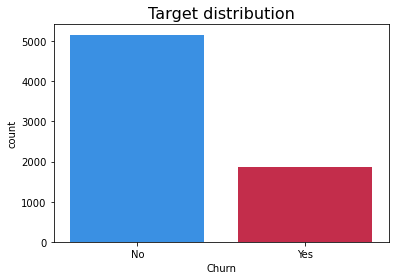

In [33]:
plt.figure(figsize=(6,4))
cp = sns.countplot(df['Churn'], palette=['dodgerblue', 'crimson'])
cp.set_xticklabels(labels = ['No', 'Yes'])
plt.title('Target distribution', fontsize=16)

plt.show()

**Figure 1.** Target 'Churn' categories distribution.

The dataset is clearly unbalanced with respect to the target 'Churn' in a near 3:1 ratio:

In [54]:
churn = df[df['Churn']=='Yes']
no_churn = df[df['Churn']=='No']
churn_perc = (len(churn) / len(df)) * 100
no_churn_perc = (len(no_churn) / len(df)) * 100

print(f'Churn customers: {len(churn)} ({churn_perc:.2f}%)')
print(f'No-Churn customers: {len(no_churn)} ({no_churn_perc:.2f}%)')

Churn customers: 1869 (26.58%)
No-Churn customers: 5163 (73.42%)


#### Features groups inspection

We'll inspect the features distributions with respect to (wrt) the target dividing them by the 3 groups we specified at the beginning.

##### Group 1 - Customer Demographic information
Features: gender, SeniorCitizen, Partner and Dependents.

In [32]:
f_1=['gender', 'SeniorCitizen', 'Partner', 'Dependents']

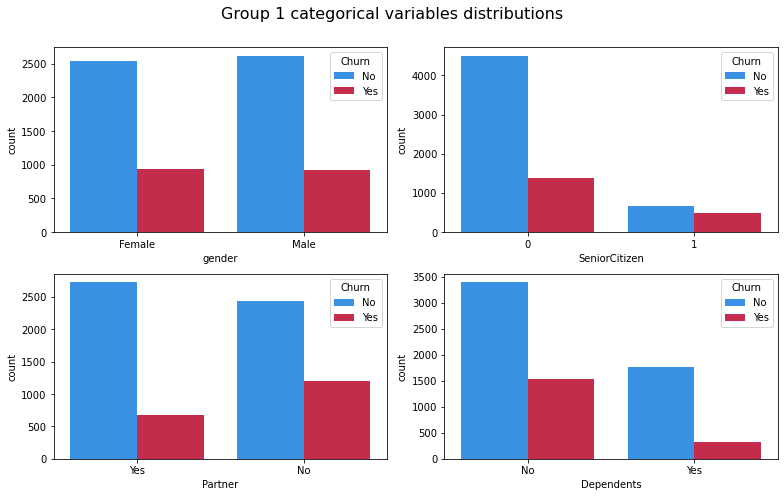

In [33]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (11,7))

for i in range(len(f_1)):
    plt.subplot(2,2,i+1)
    ax = sns.countplot(f_1[i], data=df, hue="Churn", palette=['dodgerblue','crimson'])

plt.suptitle('Group 1 categorical variables distributions', fontsize=16)   
plt.tight_layout()
plt.subplots_adjust(top=0.9) 

**Figure 2.** Customers demographic information features countplots with respect to the target.

- The number of senior citizens is low and they have a higher churn rate.  
- Customers without partners or dependents have higher churn rate (they don't share sevices and take the decision of leaving the company on their own)

##### Group 2 - Customers account information
Categorical Features: Contract, PaperlessBilling, PaymentMethod.  
Continuous Features: tenure, MonthlyCharges and TotalCharges.  

In [34]:
f_2a = ['Contract','PaperlessBilling', 'PaymentMethod']  #-> categorical
f_2b = ['tenure', 'MonthlyCharges', 'TotalCharges']      #-> continuous

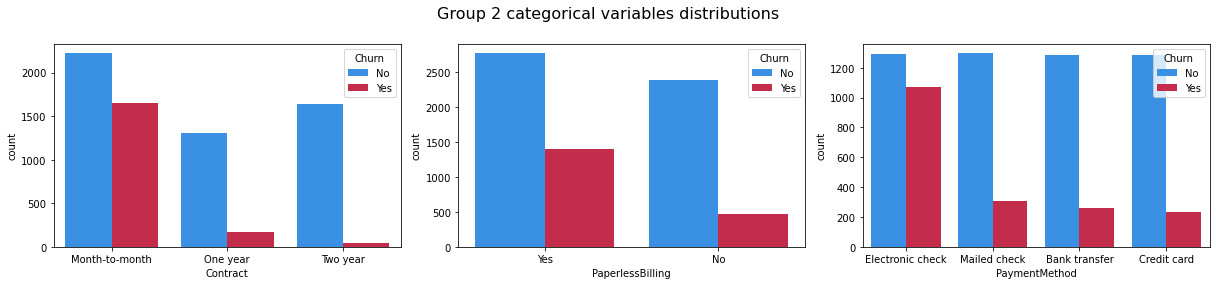

In [35]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (17,4))

for i in range(len(f_2a)):
    plt.subplot(1,3,i+1)
    ax = sns.countplot(f_2a[i], data=df, hue="Churn", palette=['dodgerblue','crimson'])

plt.suptitle('Group 2 categorical variables distributions', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85) 

**Figure 3.** Customers account information categorical features countplots with respect to the target.

• Month-to-month contracts have a high churn rate, probably due to customers testing the company services in a month period and then leaving.   
• Paperless Billing shows higher churning, what can be associated with problems with the electronic receipt.  
• The electronic check payment method has a very high rate of customers leaving services.

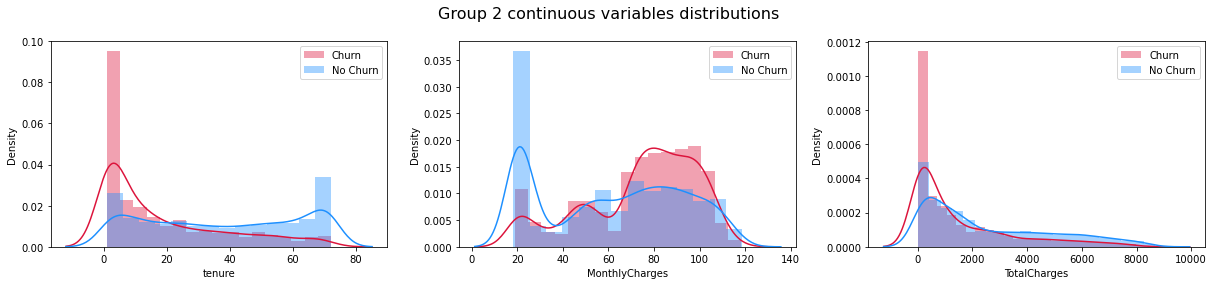

In [99]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (17,4))

for i in range(len(f_2b)):
    plt.subplot(1,3,i+1)
    ax = sns.distplot(df[df['Churn']=='Yes'][f_2b[i]], label='Churn', color='crimson')
    ax = sns.distplot(df[df['Churn']=='No'][f_2b[i]], label='No Churn', color='dodgerblue')
    plt.legend(loc= 'upper right')

plt.suptitle('Group 2 continuous variables distributions', fontsize=16)
plt.tight_layout()

**Figure 4.** Customers account information continuous features distributions with respect to the target.

• Low tenure customers (1st month mostly) have higher churn rate, what is related with the Month-to-month contracts rate in **Figure 3**. We'll continue inspecting the feature 'tenure' in next section (*).    
• Monthly expensive contracts show higher churning.

##### Group 3 - Customer acquired services.
Features: PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV and StreamingMovies.

In [36]:
f_3 = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

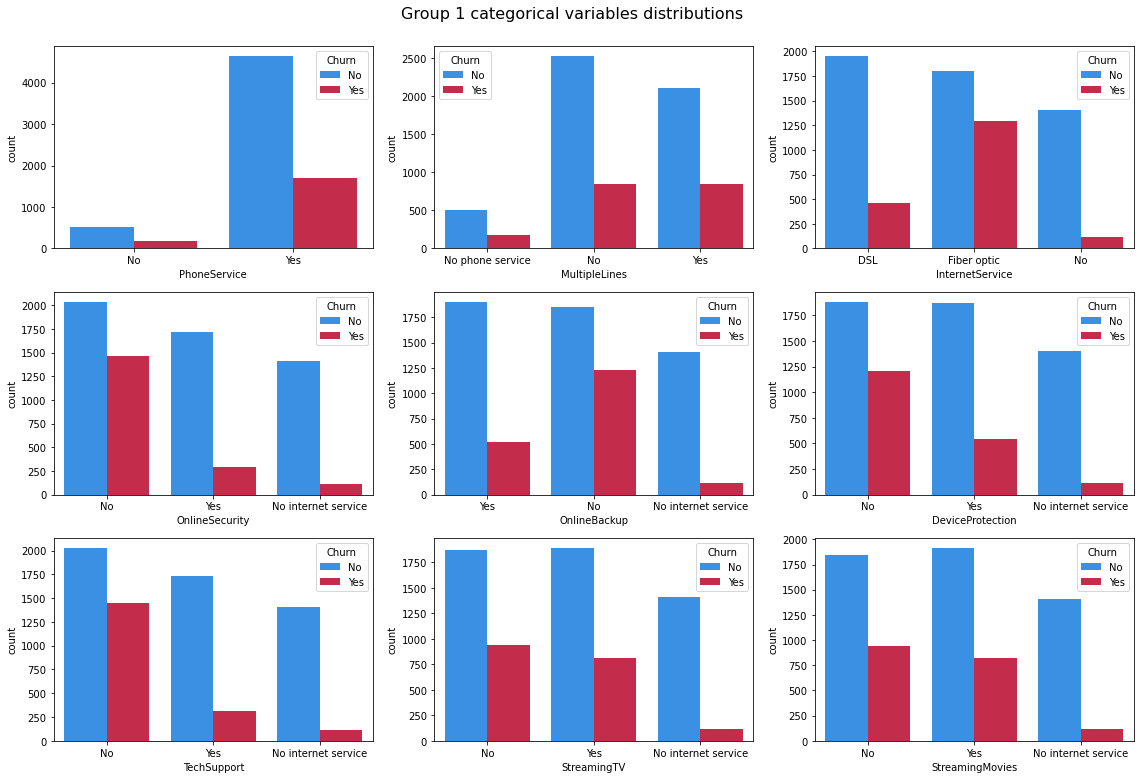

In [89]:
fig = plt.subplots(nrows = 3, ncols = 3,figsize = (16,11))

for i in range(len(f_3)):
    plt.subplot(3,3,i+1)
    ax = sns.countplot(f_3[i], data=df, hue="Churn", palette=['dodgerblue','crimson'])

plt.suptitle('Group 1 categorical variables distributions', fontsize=16)   
plt.tight_layout()
plt.subplots_adjust(top=0.93) 

**Figure 5.** Customers acquired services information features distributions with respect to the target.

• We can identify problems with the company fiber optic service.  
• Contracts with no security (online security, online backup, device protection) and technical support services show higher churning.

#####  tenure vs each group  

* tenure vs Group 1 - Customer Demographic information

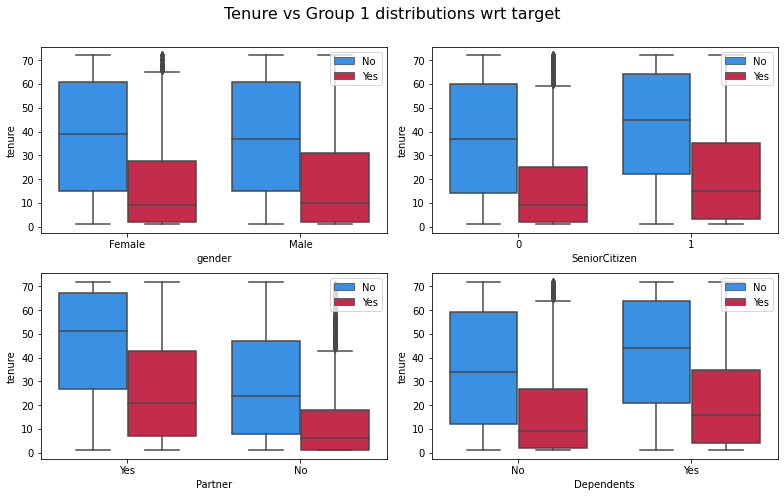

In [44]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (11,7))

for i in range(len(f_1)):
    plt.subplot(2,2,i+1)
    ax = sns.boxplot(f_1[i], 'tenure', data=df, hue="Churn", palette=['dodgerblue','crimson'])
    plt.legend(loc='upper right')
    
plt.suptitle('Tenure vs Group 1 distributions wrt target', fontsize=16)   
plt.tight_layout()
plt.subplots_adjust(top=0.9) 

**Figure 6.** Feature 'tenure' vs Group 1 variables (customer demographic information) distributions wrt to the target.

• Customers with no partners or dependents (which had a higher churn rate) have lower tenures.

* tenure vs Group 2 - Customers account information 

      A. Categorical variables 

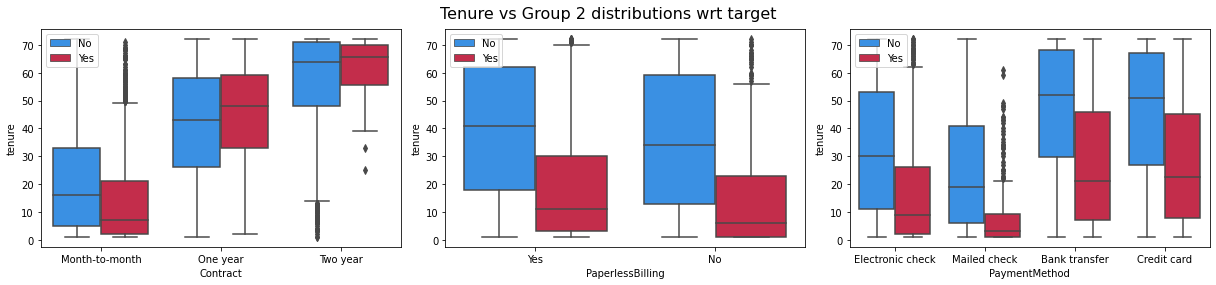

In [46]:
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (17,4))
for i in range(len(f_2a)):
    plt.subplot(1,3,i+1)
    ax = sns.boxplot(f_2a[i], 'tenure', data=df, hue="Churn", palette=['dodgerblue','crimson'])
    plt.legend(loc='upper left')
    
plt.suptitle('Tenure vs Group 2 distributions wrt target', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9) 

**Figure 7.** Feature 'tenure' vs Group 2 variables (customers account information) distributions wrt to the target.

• Shorter contracts have lower tenures, and as we saw before, monthly contracts customers have a high churn rate in the first year.  
• The electronic payment method contracts high churn rate we had noticed is concentrated within the first 2 years, and the same happens with the paperless billing contracts.     

    B. Continuous variables (*)

With the continues variables it will not be useful to visualize boxplots, instead we will take a different analysis approach, and we will only do it with 'MonthlyCharges' given that with 'TotalCharges' will be redundant.  

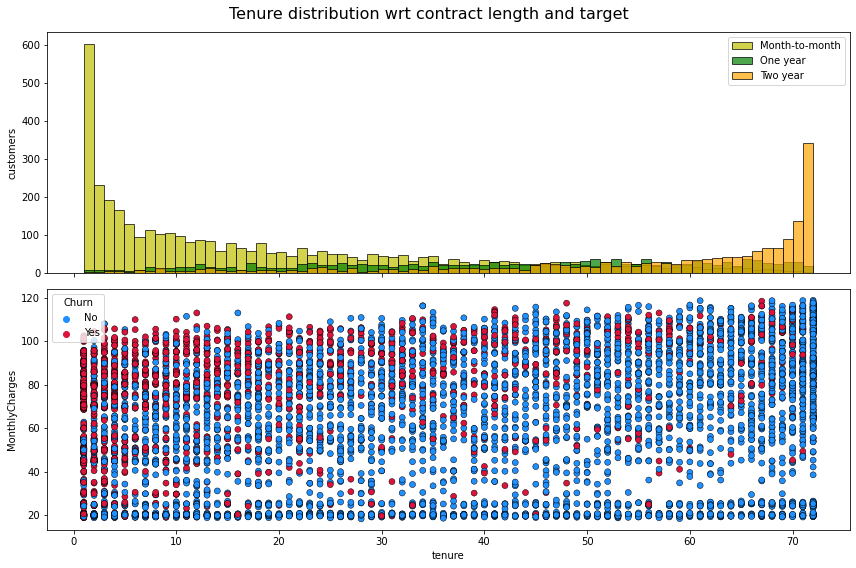

In [16]:
fig, ax = plt.subplots(2, 1,figsize = (12,8), sharex=True)

c = ['y', 'g', 'orange']
l = df['Contract'].unique()

for i in range(len(contract_length)):
    ax[0].hist(df[df['Contract']==contract_length[i]]['tenure'], edgecolor='black', bins=72, color=c[i], density=False, alpha=0.7, label=l[i])
    ax[0].set_ylabel('customers')
    ax[0].legend(loc='upper right')
    ax[0].set_yscale('linear')
    
sns.scatterplot(x = df['tenure'],y = df['MonthlyCharges'],data = df,hue = 'Churn', palette=['dodgerblue','crimson'], alpha=1 ,edgecolor = 'black', ax=ax[1]);

plt.suptitle('Tenure distribution wrt contract length and target', fontsize=16)
plt.tight_layout()

**Figure 8.** Above: tenure distribution wrt duration of the contract (one month, one year, two years). Below: tenure against MonthlyCharges wrt target.

• As we have already seen, a large number of month-to-month contracts last 1 month.   
• Most customers who leave the company do it fast, within the first year. Most of this contracts are the more expensive ones (higher monthly charges).  
• Customers that stay tend to have 2 year contracts.  

* tenure vs Group 3

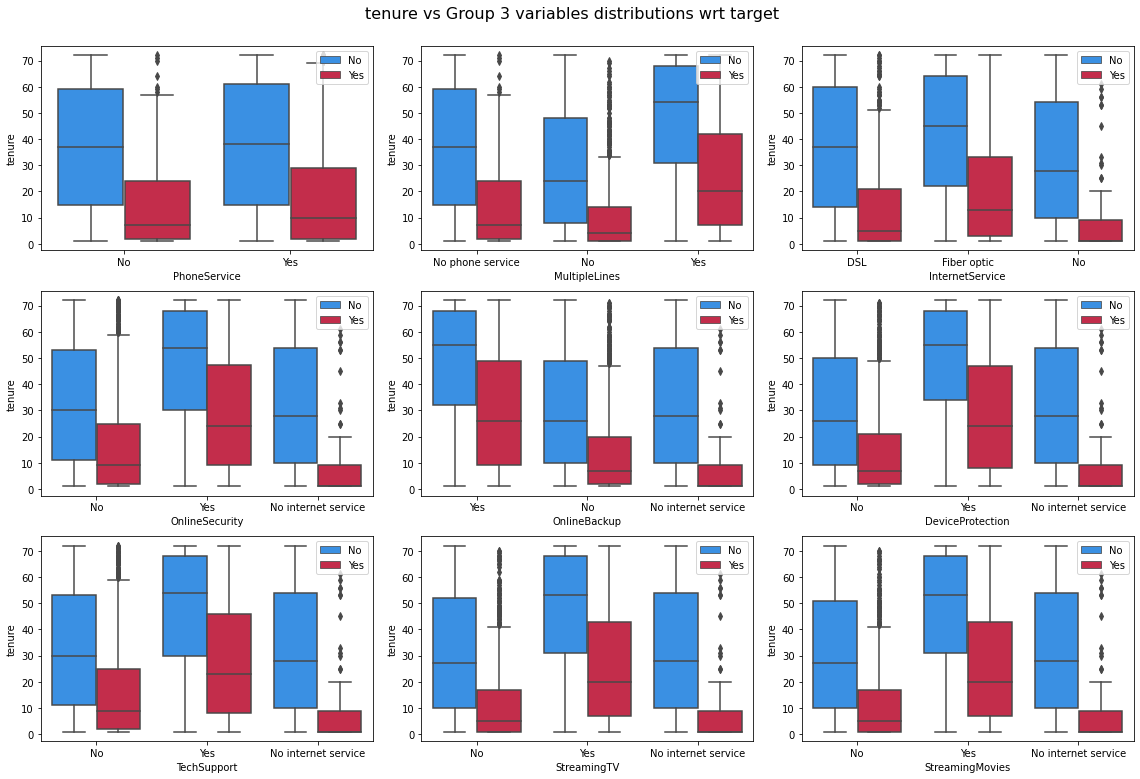

In [49]:
fig = plt.subplots(nrows = 3, ncols = 3,figsize = (16,11))

for i in range(len(f_3)):
    plt.subplot(3,3,i+1)
    ax = sns.boxplot(f_3[i], 'tenure',  data=df, hue="Churn", palette=['dodgerblue','crimson'])
    plt.legend(loc='upper right')
    
plt.suptitle('tenure vs Group 3 variables distributions wrt target', fontsize=16)   
plt.tight_layout()
plt.subplots_adjust(top=0.93) 

**Figure 9.**  Feature 'tenure' vs Group 3 variables (customer acquired services) distributions wrt to the target.

• The high churn rate we saw in fiber optic service contratcs is concentrated the first year.  
• The same happens with contracts with no security (online security, online backup, device protection) and technical support services that had showed high churning.

##### MonthlyCharges vs each group

* MonthlyCharges vs Group 1

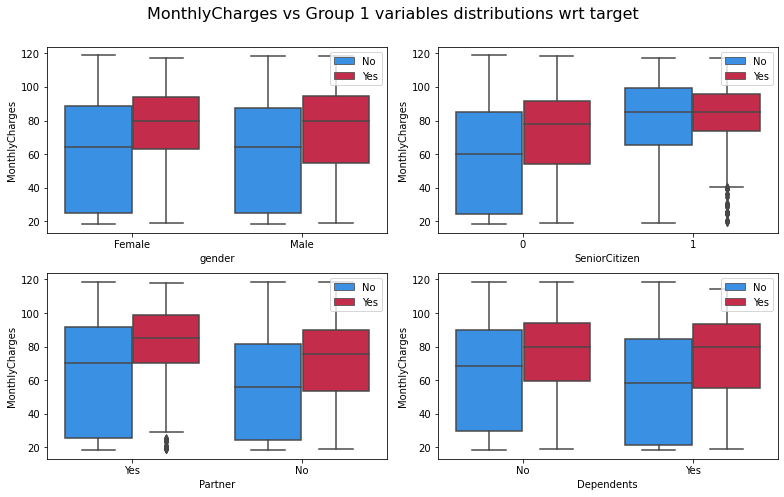

In [54]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (11,7))

for i in range(len(f_1)):
    plt.subplot(2,2,i+1)
    ax = sns.boxplot(f_1[i], 'MonthlyCharges', data=df, hue="Churn", palette=['dodgerblue','crimson'])
    plt.legend(loc='upper right')
    
plt.suptitle('MonthlyCharges vs Group 1 variables distributions wrt target', fontsize=16)   
plt.tight_layout()
plt.subplots_adjust(top=0.9) 

**Figure 10.**  Feature 'MonthlyCharges' vs Group 1 variables (customer demographic information) distributions wrt to the target.

• The churn cases are clearly concentrated in the more expensive contracts.

* MonthlyCharges vs Group 2

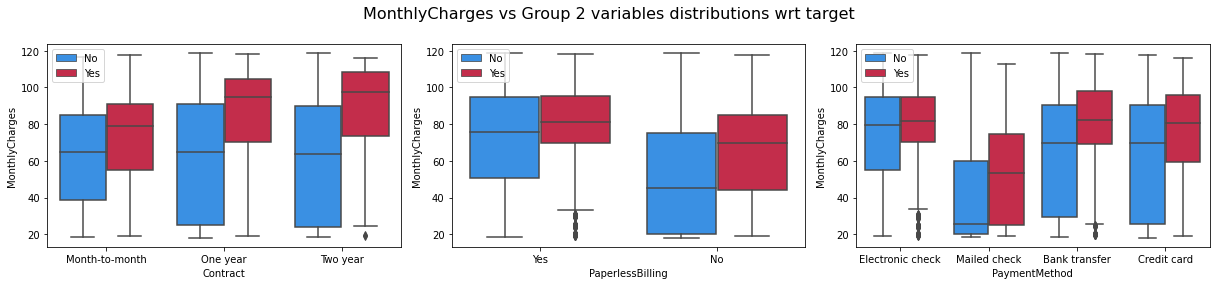

In [55]:
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (17,4))

for i in range(len(f_2a)):
    plt.subplot(1,3,i+1)
    ax = sns.boxplot(f_2a[i], 'MonthlyCharges', data=df, hue="Churn", palette=['dodgerblue','crimson'])
    plt.legend(loc='upper left')
    
plt.suptitle('MonthlyCharges vs Group 2 variables distributions wrt target', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85) 

**Figure 11.** Feature 'MonthlyCharges' vs Group 2 variables (customers account information) distributions wrt to the target.

• For all contract lengths, churning is concentrated in the most expensive contracts.    
• High cost tolerance is lower for shorter contracts.  
• Paperless billing and electronic check payment contracts are more expensive.  

* MonthlyCharges vs Group 3

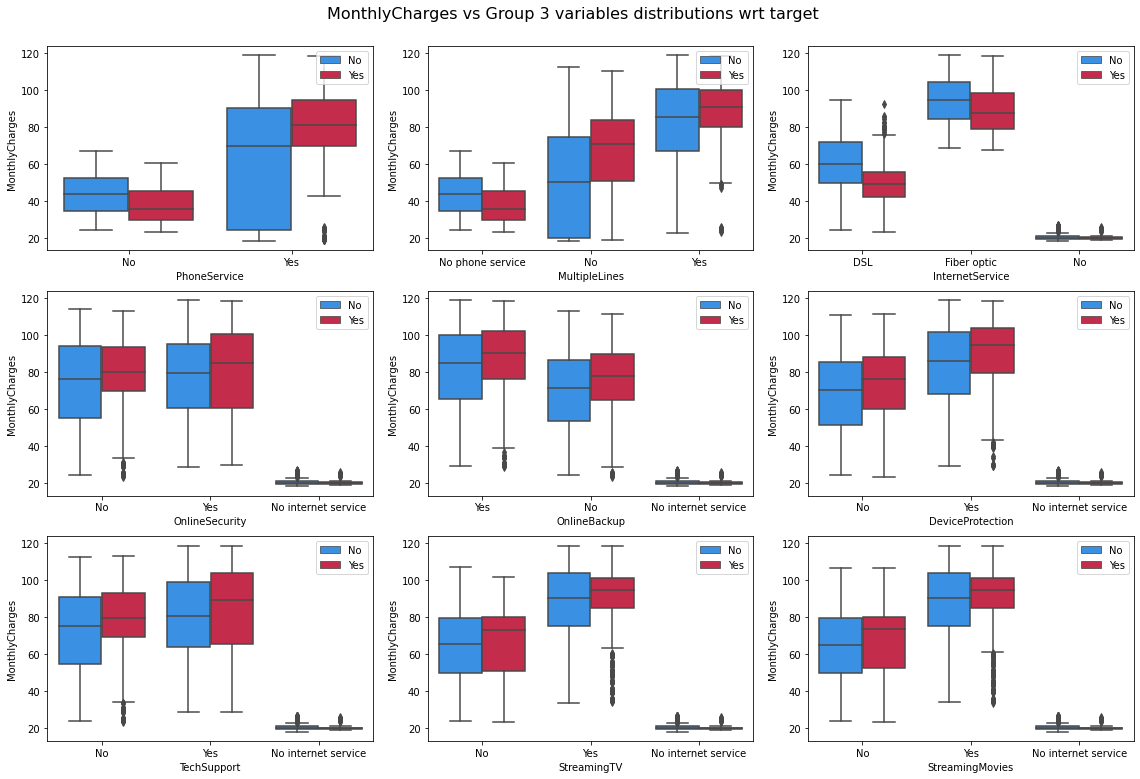

In [56]:
fig = plt.subplots(nrows = 3, ncols = 3,figsize = (16,11))

for i in range(len(f_3)):
    plt.subplot(3,3,i+1)
    ax = sns.boxplot(f_3[i], 'MonthlyCharges', data=df, hue="Churn", palette=['dodgerblue','crimson'])
    plt.legend(loc='upper right')

plt.suptitle('MonthlyCharges vs Group 3 variables distributions wrt target', fontsize=16)   
plt.tight_layout()
plt.subplots_adjust(top=0.93) 

**Figure 12.** Feature 'MonthlyCharges' vs Group 2 variables (customer acquired services) distributions wrt to the target.

• Fiber optic service monthly charges are much more expensive than DSL.

#### Encoding

Target inspecion:

In [15]:
df['Churn'].unique()

array(['No', 'Yes'], dtype=object)

Label Encoding:

In [16]:
df['Churn'] = LabelEncoder().fit_transform(df['Churn'])

Features Encoding:

In [17]:
df_encoded = pd.get_dummies(df)

In [18]:
df_encoded.shape

(7032, 46)

#### Correlation

We inspect correlation between each feature and the target:

In [21]:
corr = df_encoded.corr()

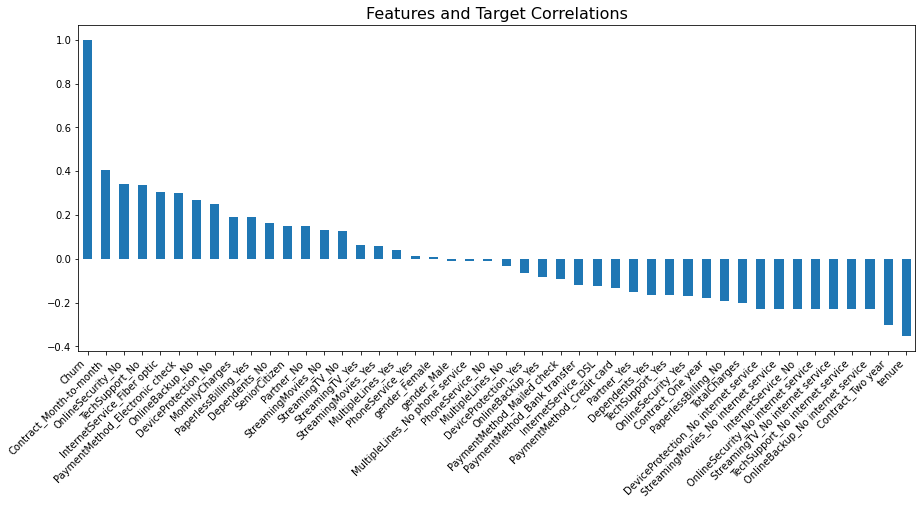

In [24]:
plt.figure(figsize=(15,6))
plt.title('Features and Target Correlations', fontsize=16)

df_encoded.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

**Figure 13.** Correlations between features and the target 'Churn'.

There's a positive correlacion between the target and Month-to-month contracts, no online security and no tech support services contracts.    
Tenure and Two-year contracts have a negative correlation with the target.

### 2. Data Preparation 
---

In [19]:
X = df_encoded.drop('Churn', axis=1)

In [20]:
y = df_encoded['Churn']

Data split:

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

Split inspection:

In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5274, 45)
(5274,)
(1758, 45)
(1758,)


In [23]:
print(f'positive cases (churn) in test set: {y_test.sum()}')
print(f'positive cases (churn) in train set: {y_train.sum()}')
print(f'negative cases (no-churn) in test set: {len(y_test)-y_test.sum()}')
print(f'negative cases (no-churn) in train set: {len(y_train)-y_train.sum()}')

positive cases (churn) in test set: 458
positive cases (churn) in train set: 1411
negative cases (no-churn) in test set: 1300
negative cases (no-churn) in train set: 3863


### 3. Models Training, Evaluation and Error Analysis
---

#### Model - XGBoost 

Grid Search:

In [245]:
grid = {                                    
        'max_depth': [2,3,4,5],
        'learning_rate': [0.01, 0.1, 0.5, 1],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0, 0.1, 1.0, 10.0],
        'scale_pos_weight':[0,3,5,10,25]
        }

In [246]:
model = XGBClassifier(objective='binary:logistic',
                      seed=42,
                      subsample=0.9,         
                      colsample_bytree=0.5)  

In [247]:
optimal_params = GridSearchCV(estimator=model, 
                              param_grid=grid, 
                              scoring='roc_auc',  
                              n_jobs=-1, 
                              cv=5)

In [248]:
start = time()

optimal_params.fit(X_train, y_train,
                   eval_metric=['aucpr','logloss', 'error'],
                   eval_set=[(X_test, y_test)],
                   verbose=False)               

elapsed = time() - start
print(elapsed)

449.30488634109497


In [249]:
print(optimal_params.best_params_)

{'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'reg_lambda': 10.0, 'scale_pos_weight': 3}


Model instantiation with grid searh best params:

In [29]:
xgb_t = XGBClassifier(booster='gbtree', 
                     objective='binary:logistic',
                     gamma=1, 
                     learning_rate=0.1, 
                     max_depth=2, 
                     reg_lambda=10,
                     scale_pos_weight=3, 
                     random_state=42)

Model training:

In [31]:
xgb_t.fit(X_train, y_train,                  
        eval_metric=["error", "logloss", "aucpr"], 
        verbose=False, 
        eval_set=[(X_train, y_train), (X_test, y_test)])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=3, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [96]:
y_pred = xgb_t.predict(X_test)    
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1300
           1       0.49      0.81      0.61       458

    accuracy                           0.73      1758
   macro avg       0.70      0.76      0.70      1758
weighted avg       0.80      0.73      0.75      1758



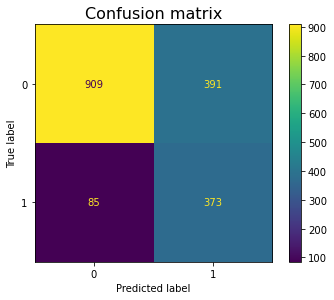

In [152]:
plot_confusion_matrix(xgb_t, X_test, y_test)   
plt.title('Confusion matrix',fontsize=16)
plt.show()

**Figure 14.** XGBoost model outcomes summary.

In [32]:
results = xgb_t.evals_result()                            
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

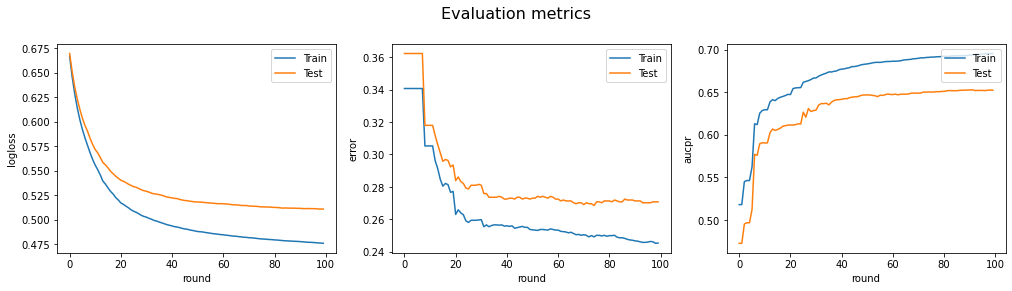

In [95]:
fig, ax = plt.subplots(1,3,figsize = (17,4))

eval_metrics=["logloss", "error", "aucpr"]

for i in range(len(eval_metrics)):
    plt.subplot(1,3,i+1)
    ax = plt.plot(x_axis, results['validation_0'][eval_metrics[i]], label='Train') 
    ax = plt.plot(x_axis, results['validation_1'][eval_metrics[i]], label='Test')
    plt.xlabel('round')
    plt.legend(loc='upper right')
    ax=plt.ylabel(eval_metrics[i])

plt.suptitle('Evaluation metrics', fontsize=16)
plt.subplots_adjust(top=0.85) 
plt.show()

**Figure 15.** Model error metrics per round for train and test sets.

#### Feature importance

<Figure size 1080x360 with 0 Axes>

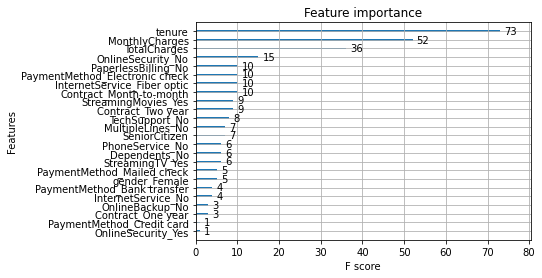

In [118]:
plt.figure(figsize=(15,5))
plot_importance(xgb_t)
plt.show()

**Figure 16.** Importance of each feature during XGBoost model building.

### 4. Conclusion

Features 'Tenure' and 'MonthlyCharges', both belonging to Group 2 (Customer account information) and the ones studied more in depth in the EDA section, were the ones more important during the construction of the model. It is also worth noting that 'Tenure' had shown a high (negative) correlation with the target.

After hyperparameter tuning our model predicted 81% of the churn cases, which we consider an acceptable result in a first instance but that could be improved. We will continue working on feature engineering and making the corresponding and deeper hyperparameter adjustments to exceed our current results. 